In [1]:
import numpy as np
from random import random, choice

from matplotlib import cm
from time import sleep
from colosseumrl.envs.tron import TronGridEnvironment, TronRender, TronRllibEnvironment

import gym
from gym import Env
from gym.spaces import Dict, Discrete, Box

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.rllib.agents.dqn import DQNTrainer, DEFAULT_CONFIG

from ray.rllib.models.preprocessors import Preprocessor
from ray.rllib.models import ModelCatalog

from typing import Tuple

SEED = 1517
np.random.seed(SEED)

In [2]:
class TronRender(TronRender):
    def __init__(self, board_size: int, num_players: int,
                 window_size: Tuple[int, int] = (600, 600),
                 outside_border: int = 25,
                 grid_space_ratio: float = 6,
                 winner_player: int = None):
        
        super().__init__(board_size, num_players,window_size,outside_border,grid_space_ratio,winner_player)
        
        self.colors = cm.plasma(np.linspace(0.1, 0.9, 2))
        self.colors = np.minimum(self.colors * 1.3, 1.0)
        self.colors = np.repeat(self.colors, 2, axis=0)        

In [3]:
class TronExtractBoard(Preprocessor):
    """ Wrapper to extract just the board from the game state and simplify it for the network. """        
    def _init_shape(self, obs_space, options):
        board_size = env.observation_space['board'].shape[0]
        return (board_size + 2, board_size + 2, 2)
    
    def transform(self, observation):
        # Pretty hacky way to get the current player number
        # Requires having exactly 4 players
        board = observation['board']
        hor_offset = board.shape[0] // 2 + 2
        top_player = board[1, hor_offset]
        player_number = {1: 0, 4: 1, 3: 2, 2: 3}[top_player]

        return self._transform(observation, player_number)

    def _transform(self, observation, rotate: int = 0):
        board = observation['board'].copy()
        
        # Make all enemies look the same
        board[board > 1] = -1
        
        # Mark where all of the player heads are
        heads = np.zeros_like(board)
        
        if (rotate != 0):
            heads.ravel()[observation['heads']] += 1 + ((observation['directions'] - rotate) % 4)
            
            board = np.rot90(board, k=rotate)
            heads = np.rot90(heads, k=rotate)
            
        else:
            heads.ravel()[observation['heads']] += 1 + observation['directions']
            
        # Pad the outsides so that we know where the wall is
        board = np.pad(board, 1, 'constant', constant_values=-1)
        heads = np.pad(heads, 1, 'constant', constant_values=-1)
        
        # Combine together
        board = np.expand_dims(board, -1)
        heads = np.expand_dims(heads, -1)
        
        return np.concatenate([board, heads], axis=-1)

In [4]:
class TeamTron(TronRllibEnvironment):
    def step(self, action_dict):
        observation, reward_dict, done_dict, info_dict = super().step(action_dict)
        
#         for i, j in reward_dict.items():
#             if j == 10:
#                 reward_dict[i] *= 10
#             if j == -1:
#                 reward_dict[i] = -2
        
        
        r0 = reward_dict.get('0', 0)
        r1 = reward_dict.get('1', 0)
        r2 = reward_dict.get('2', 0)
        r3 = reward_dict.get('3', 0)
        
        for i, j in reward_dict.items():
            if i =='0':
                reward_dict[i] += 0.5 * r1
            elif i =='1':
                reward_dict[i] += 0.5 * r0
            elif i =='2':
                reward_dict[i] += 0.75 * r3
            elif i =='3':
                reward_dict[i] += 0.25 * r2
        
#         for i, j in reward_dict.items():
#             if j == -1:
#                 reward_dict[i] = -100
        
        return observation, reward_dict, done_dict, info_dict

In [5]:
def test(render, env, trainer, frame_time = 0.4):
    extractBoard = TronExtractBoard(env.observation_space)
    policy = trainer.get_policy("training_policy")
    policy.cur_epsilon_value = 0
    render.close()
    obsDict = env.reset()
    doneDict = {'__all__' : False}
    actionDict = {}
    rewardDict = {}
    cumulative_reward = 0
    
    teamWinner = 0
    terminal = False 
    
    while not doneDict['__all__'] and not terminal:
        for player, obs in obsDict.items():
            if player == '0' or player == '1':
                actionDict[player] = trainer.compute_action(obs, prev_action=actionDict.get(player, None), prev_reward=rewardDict.get(player, None), policy_id='training_policy')
            else:
                actionDict[player] = trainer.compute_action(obs, prev_action=actionDict.get(player, None), prev_reward=rewardDict.get(player, None), policy_id='opponent_policy')
                
        obsDict, rewardDict, doneDict, results = env.step(actionDict)
        
        if rewardDict['0'] < 0 and rewardDict['1'] < 0 and rewardDict['2'] < 0 and rewardDict['3'] < 0:
            terminal = True
        elif rewardDict['0'] < 0 and rewardDict['1'] < 0:
            teamWinner = 2
            terminal = True
        elif rewardDict['2'] < 0 and rewardDict['3'] < 0:
            teamWinner = 1
            terminal = True
        
        render.render(env.state)
        sleep(frame_time)

    render.render(env.state)
    print()
    print(rewardDict)
    if teamWinner == 0:
        print("Tie Game!")
    else:
        print("Team "+str(teamWinner)+" wins")
    
    return teamWinner, rewardDict

In [6]:
# Initialize training environment
ray.shutdown()
ray.init()
    
def team_environment_creater(params=None):
    return TeamTron(board_size=13, num_players=4)   
    
env = team_environment_creater()

tune.register_env("tron_team", team_environment_creater)
ModelCatalog.register_custom_preprocessor("tron_prep", TronExtractBoard)

# Configure Deep Q Learning for multi-agent training
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 4
config["timesteps_per_iteration"] = 128
config['target_network_update_freq'] = 256
config['buffer_size'] = 10_000
config['schedule_max_timesteps'] = 100_000
config['exploration_fraction'] = 0.9
config['compress_observations'] = False
config['num_envs_per_worker'] = 1
config['train_batch_size'] = 256
config['n_step'] = 2

# All of the models will use the same network as before
agent_config = {
    "model": {
        "vf_share_layers": True,
        "conv_filters": [(64, 5, 2), (128, 3, 2), (256, 3, 2)],
        "fcnet_hiddens": [128],
        "custom_preprocessor": 'tron_prep'
    }
}
config['multiagent'] = {
        "policies_to_train": ["training_policy", "opponent_policy"],
        "policy_mapping_fn": lambda x: "training_policy" if x == "0" or x == "1" else "opponent_policy",
        "policies": {"training_policy": (None, env.observation_space, env.action_space, agent_config),
                     "opponent_policy": (None, env.observation_space, env.action_space, agent_config)}
}
'''
config['multiagent'] = {
        "policies_to_train": ["mu_policy", "delta_policy","omega_policy", "zeta_policy"],
        "policy_mapping_fn": lambda x: "mu_policy" if x == "0" else if x=="1" else "opponent_policy",
        "policies": {"mu_policy": (None, env.observation_space, env.action_space, agent_config),
                     "delta_policy": (None, env.observation_space, env.action_space, agent_config),
                     "omega_policy": (None, env.observation_space, env.action_space, agent_config),
                     "zeta_policy": (None, env.observation_space, env.action_space, agent_config)}
}
'''
trainer = DQNTrainer(config, "tron_team")
num_epoch = 1000
render = TronRender(13, 4)
np.random.seed(SEED)
#checkpoint = trainer.restore('/home/andranik/ray_results/DQN_tron_team_2020-03-11_13-50-28z3s19hpt/checkpoint_1002/checkpoint-1002')

#winDict = {0:0, 1:0, 2:0}
print(env.observation_space)
print(env.action_space)
# for _ in range(5):
#     winner = test(render, env, trainer)
#     winDict[winner] += 1
#     sleep(3)
#
#print(winDict)

tiegames = []
team1wins = []
team2wins = []

training_avg_reward = []
opponent_avg_reward = []
#omega_avg_reward = []
#zeta_avg_reward = []


for epoch in range(num_epoch + 1):
    print("Training iteration: {}".format(epoch))
    res = trainer.train()
#     print("mu Average reward: {}".format(res['policy_reward_mean']['mu_policy']))
#     print("delta Average reward: {}".format(res['policy_reward_mean']['delta_policy']))
#     print("omega Average reward: {}".format(res['policy_reward_mean']['omega_policy']))
#     print("zeta Average reward: {}".format(res['policy_reward_mean']['zeta_policy']))
    if epoch % 10 == 0:
        training_avg_reward.append(res['policy_reward_mean']['training_policy'])
        opponent_avg_reward.append(res['policy_reward_mean']['opponent_policy'])
          
    
    if epoch % 100 == 0:
        checkpoint = trainer.save()
        
        winDict = {0:0, 1:0, 2:0}
        
#         training_avg_reward.append(res['policy_reward_mean']['training_policy'])
#         opponent_avg_reward.append(res['policy_reward_mean']['opponent_policy'])
        
        
        for _ in range(25):
            winner, rd = test(render, env, trainer)
            winDict[winner] += 1
            
#             r0 = rd['0']
#             r1 = rd['1']
#             r2 = rd['2']
#             r3 = rd['3']
        
    
        tiegames.append(winDict[0]/25)
        team1wins.append(winDict[1]/25)
        team2wins.append(winDict[2]/25)

2020-03-15 21:39:23,477	INFO resource_spec.py:212 -- Starting Ray with 3.37 GiB memory available for workers and up to 1.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-15 21:39:23,768	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-03-15 21:39:24,629	INFO trainer.py:377 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-15 21:39:24,693	INFO trainer.py:524 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-03-15 21:39:24,945	WARNING catalog.py:390 -- DeprecationWarning: Custom preprocessors are deprecated, since they sometimes conflict with the built-in preprocessors for handling complex observation spaces. Please use wrapper classes around your environment instead of preprocessors.
2020-03-15 21:39:30,

Dict(board:Box(13, 13), deaths:Box(4,), directions:Box(4,), heads:Box(4,))
Discrete(3)
Training iteration: 0
(pid=77253) 2020-03-15 21:39:46,927	WARNING catalog.py:390 -- DeprecationWarning: Custom preprocessors are deprecated, since they sometimes conflict with the built-in preprocessors for handling complex observation spaces. Please use wrapper classes around your environment instead of preprocessors.
(pid=77259) 2020-03-15 21:39:47,058	WARNING catalog.py:390 -- DeprecationWarning: Custom preprocessors are deprecated, since they sometimes conflict with the built-in preprocessors for handling complex observation spaces. Please use wrapper classes around your environment instead of preprocessors.
(pid=77257) 2020-03-15 21:39:47,049	WARNING catalog.py:390 -- DeprecationWarning: Custom preprocessors are deprecated, since they sometimes conflict with the built-in preprocessors for handling complex observation spaces. Please use wrapper classes around your environment instead of preproces

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



{'0': 1.5, '1': 1.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': 1.75, '3': 1.25}
Team 2 wins

{'0': 4.0, '1': 9.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': -1.5, '1': -1.5, '2': 1.75, '3': 1.25}
Team 2 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 1.5, '1': 1.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': 1.5, '1': 1.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 4.0, '1': 9.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -

Training iteration: 2


Training iteration: 3


Training iteration: 4


Training iteration: 5


Training iteration: 6


Training iteration: 7
Training iteration: 8
Training iteration: 9
Training iteration: 10
Training iteration: 11
Training iteration: 12
Training iteration: 13
Training iteration: 14
Training iteration: 15
Training iteration: 16
Training iteration: 17
Training iteration: 18
Training iteration: 19
Training iteration: 20
Training iteration: 21
Training iteration: 22
Training iteration: 23
Training iteration: 24
Training iteration: 25
Training iteration: 26
Training iteration: 27
Training iteration: 28
Training iteration: 29
Training iteration: 30
Training iteration: 31
Training iteration: 32
Training iteration: 33
Training iteration: 34
Training iteration: 35
Training iteration: 36
Training iteration: 37
Training iteration: 38
Training iteration: 39
Training iteration: 40
Training iteration: 41
Training iteration: 42
Training iteration: 43
Training iteration: 44
Training iteration: 45
Training iteration: 46
Training iteration: 47
Training iteration: 48
Training iteration: 49
Training itera

Training iteration: 233
Training iteration: 234
Training iteration: 235
Training iteration: 236
Training iteration: 237
Training iteration: 238
Training iteration: 239
Training iteration: 240
Training iteration: 241
Training iteration: 242
Training iteration: 243
Training iteration: 244
Training iteration: 245
Training iteration: 246
Training iteration: 247
Training iteration: 248
Training iteration: 249
Training iteration: 250
Training iteration: 251
Training iteration: 252
Training iteration: 253
Training iteration: 254
Training iteration: 255
Training iteration: 256
Training iteration: 257
Training iteration: 258
Training iteration: 259
Training iteration: 260
Training iteration: 261
Training iteration: 262
Training iteration: 263
Training iteration: 264
Training iteration: 265
Training iteration: 266
Training iteration: 267
Training iteration: 268
Training iteration: 269
Training iteration: 270
Training iteration: 271
Training iteration: 272
Training iteration: 273
Training iterati

Training iteration: 455
Training iteration: 456
Training iteration: 457
Training iteration: 458
Training iteration: 459
Training iteration: 460
Training iteration: 461
Training iteration: 462
Training iteration: 463
Training iteration: 464
Training iteration: 465
Training iteration: 466
Training iteration: 467
Training iteration: 468
Training iteration: 469
Training iteration: 470
Training iteration: 471
Training iteration: 472
Training iteration: 473
Training iteration: 474
Training iteration: 475
Training iteration: 476
Training iteration: 477
Training iteration: 478
Training iteration: 479
Training iteration: 480
Training iteration: 481
Training iteration: 482
Training iteration: 483
Training iteration: 484
Training iteration: 485
Training iteration: 486
Training iteration: 487
Training iteration: 488
Training iteration: 489
Training iteration: 490
Training iteration: 491
Training iteration: 492
Training iteration: 493
Training iteration: 494
Training iteration: 495
Training iterati

Training iteration: 677
Training iteration: 678
Training iteration: 679
Training iteration: 680
Training iteration: 681
Training iteration: 682
Training iteration: 683
Training iteration: 684
Training iteration: 685
Training iteration: 686
Training iteration: 687
Training iteration: 688
Training iteration: 689
Training iteration: 690
Training iteration: 691
Training iteration: 692
Training iteration: 693
Training iteration: 694
Training iteration: 695
Training iteration: 696
Training iteration: 697
Training iteration: 698
Training iteration: 699
Training iteration: 700

{'0': -1.5, '1': -1.5, '2': 6.5, '3': 9.75}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 1.5, '1': 1.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': 9.25, '3': 1.5}
Team 2 wins

{'0': -1.5, '1': -1.5, '2': 9.25, '3': 1.5}
Team 2 wins

{'0': -1.5, '1': -1.

Training iteration: 899
Training iteration: 900

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': 9.25, '3': 1.5}
Team 2 wins

{'0': 4.0, '1': 9.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': 4.0, '1': 9.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': -1.75, '3': -1.25}
Tie Game!

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 4.0, '1': 9.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2': 9.25, '3': 1.5}
Team 2 wins

{'0': 9.5, '1': 4.0, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': 1.5, '1': 1.5, '2': -1.75, '3': -1.25}
Team 1 wins

{'0': -1.5, '1': -1.5, '2

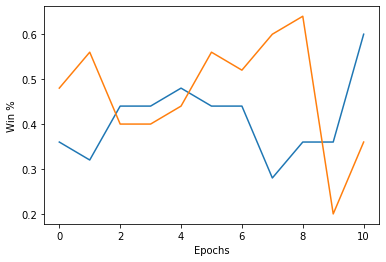

In [7]:
import matplotlib.pyplot as plt

#tiegames = [x / 5 for x in tiegames]
#team1wins = [x for x in team1wins]
#team2wins = [x for x in team2wins]

#plt.plot(tiegames)
plt.plot(team1wins)
plt.plot(team2wins)
plt.xlabel('Epochs')
plt.ylabel('Win %')
plt.show()

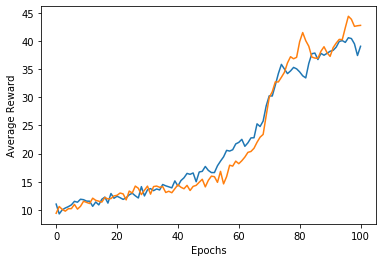

In [8]:
import matplotlib.pyplot as plt

plt.plot(training_avg_reward)
plt.plot(opponent_avg_reward)
# plt.plot(omega_avg_reward)
# plt.plot(zeta_avg_reward)
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.show()

In [9]:
# np.random.seed(SEED)
# trainer.restore(checkpoint)

# winDict = {0:0, 1:0, 2:0}

# for _ in range(25):
#     winner = test(render, env, trainer)
#     winDict[winner] += 1
#     sleep(3)

# print(winDict)

In [10]:
# num_epoch = 500
# checkpoint = trainer.restore('/home/andranik/ray_results/DQN_tron_team_2020-03-11_13-50-28z3s19hpt/checkpoint_501/checkpoint-501')

# for epoch in range(num_epoch + 1):
#     print("Training iteration: {}".format(epoch), end='')
#     res = trainer.train()
#     print(f", Average reward: {res['policy_reward_mean']['training_policy']}")
    
#     if epoch % 100 == 0:
#         checkpoint = trainer.save()